In [2]:
from pytc2.sistemas_lineales import plot_plantilla
import pytc2.filtros_digitales

import pytc2

import numpy as np
from scipy import signal as sig

import matplotlib.pyplot as plt
   
import scipy.io as sio
from scipy.io.wavfile import write

def vertical_flaten(a):

    return a.reshape(a.shape[0],1)

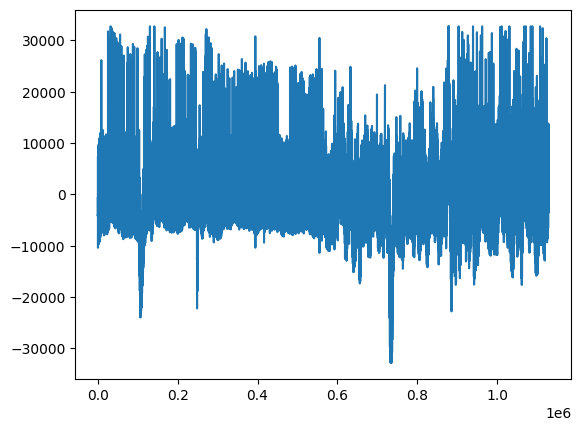

In [ ]:
##################
###### ECG #######
##################

fs_ecg = 1000 # Hz

#para listar las variables que hay en el archivo
sio.whosmat('ECG_TP4.mat')
mat_struct = sio.loadmat('./ECG_TP4.mat')

ecg_one_lead = vertical_flaten(mat_struct['ecg_lead'])

# plt.figure(1)
# plt.plot(ecg_one_lead[5000:12000])
# plt.show()

# Variables
qrs_pattern = mat_struct['qrs_pattern1'].flatten()
heartbeat_normal = mat_struct['heartbeat_pattern1'].flatten()
heartbeat_ventricular = mat_struct['heartbeat_pattern2'].flatten()
qrs_detections = mat_struct['qrs_detections'].flatten()

N = len(ecg_one_lead)

ecg_signal = ecg_one_lead / np.std(ecg_one_lead)
heartbeat_normal = heartbeat_normal / np.std(heartbeat_normal)
heartbeat_ventricular = heartbeat_ventricular / np.std(heartbeat_ventricular)
qrs_pattern = qrs_pattern / np.std(qrs_pattern)

<function matplotlib.pyplot.show(close=None, block=None)>

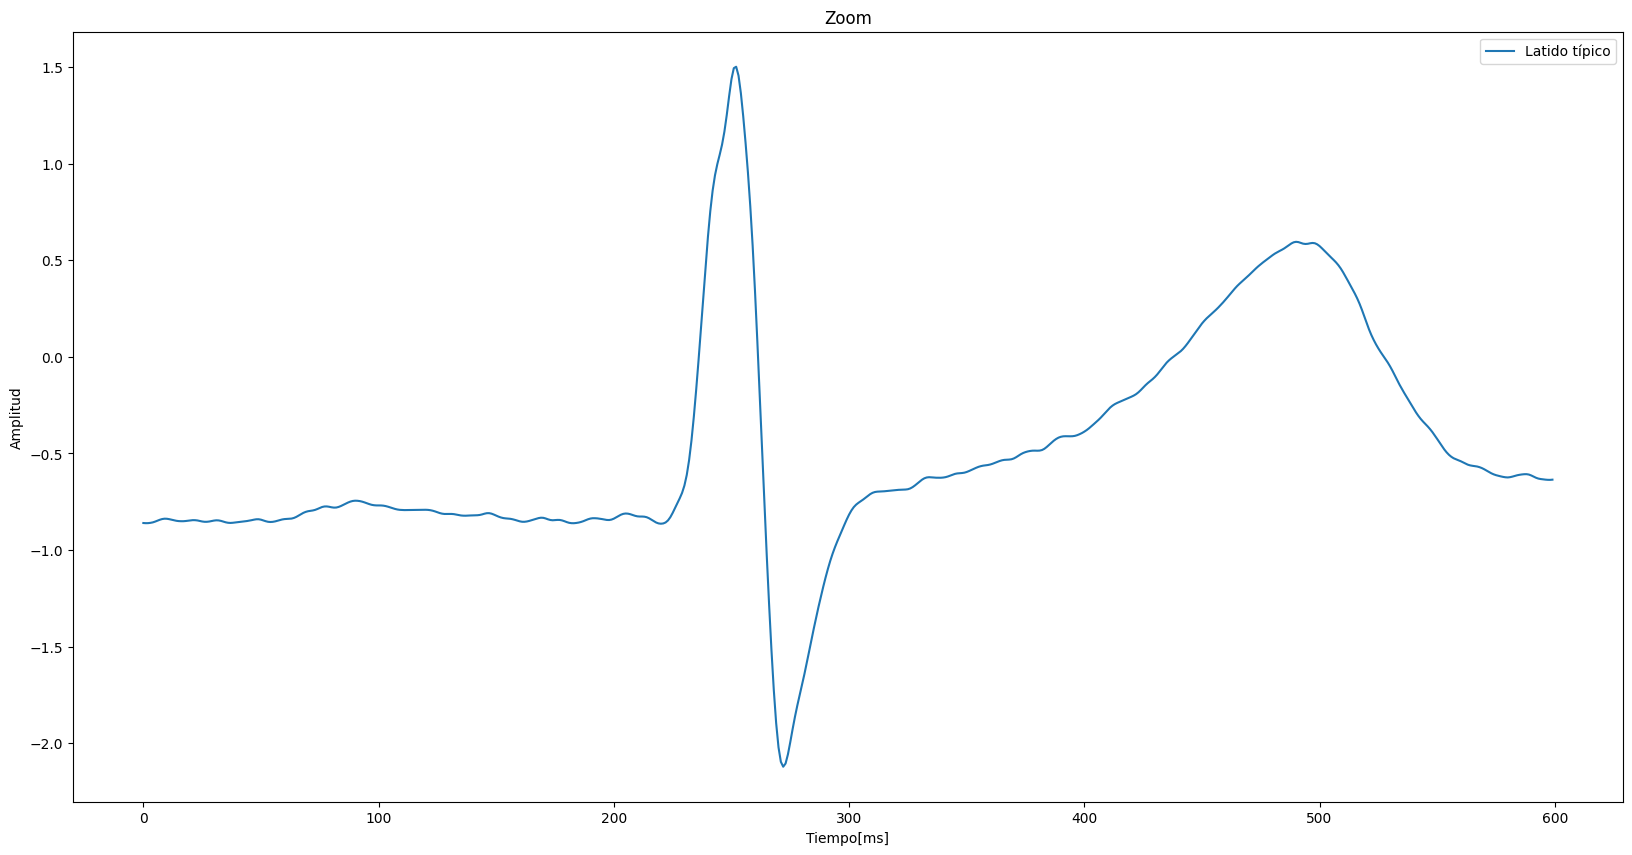

In [42]:
#%% Ubicar una onda

w_after = 350 #ms
w_before = 250 #ms

ecg_segment = ecg_signal[qrs_detections[0] - w_before : qrs_detections[0] + w_after]
t_segment = np.arange(0, len(ecg_segment))

plt.figure(figsize=(20,10))
plt.plot(t_segment, ecg_segment, label = 'Latido típico')
plt.xlabel('Tiempo[ms]')
plt.ylabel('Amplitud')
plt.title('Zoom')
plt.legend()
plt.show

### Punto a) - Plantilla de diseño:

In [ ]:
#%% Plantilla

nyq_frec= fs_ecg/2

aprox_name = 'butter'

fpass = np.array( [1.0, 35.0] ) 
ripple = 0.25 # dB #gpass
fstop = np.array( [0.1, 50.0] ) #gstop
attenuation = 20 # dB

frecs = [0, 0.1, 1, 35, 50, nyq_frec]
gain = [0, -attenuation, -ripple, -ripple, -attenuation, -np.inf]

gain = 10**(np.array(gain)/20)

### Punto b) - Definicion de parametros

Para la confección del filtro se definió que la banda de paso se ubicara entre 0.5 y 30 Hz. La cota inferior permite dejar afuera elementos de muy baja frecuencia, como pueden ser los causados por los movimientos respiratorios o las aberraciones inherentes al acople de los electrodos con la piel. Por otro lado, los 30 Hz se definen a partir del análisis energético de la señal de ECG, donde se observa que el 98% de la energia se encuentra por debajo de dicho umbral.
Las bandas de rechazo, ubicadas por debajo de 0.1 y por encima de 50 Hz, acompañan a lo mencionado sobre las bandas de paso. El limite de 0.1 es para mitigar esos aportes de frecuencias muy lentas, que por el tipo de señal a analizar, no provienen de la información propia del ECG. En el otro extremo, los 50 Hz son un numero razonables para evitar que se cuelen en nuestro análisis elementos de alta y muy alta frcuencia, generalmente ruido.
Por su parte, el ripple de un valor de 0.5 dB es razonable para los valores que nos competen, a fin de no modificar en demacía la morfología de los latidos.
Por último, con una atenuación de 40 dB, nos aseguramos que los componentes de la banda de rechazo se reduzcan lo suficiente y no molesten en la visualización de la información.

### Punto c) - Diseño de filtros

### ButterWorth

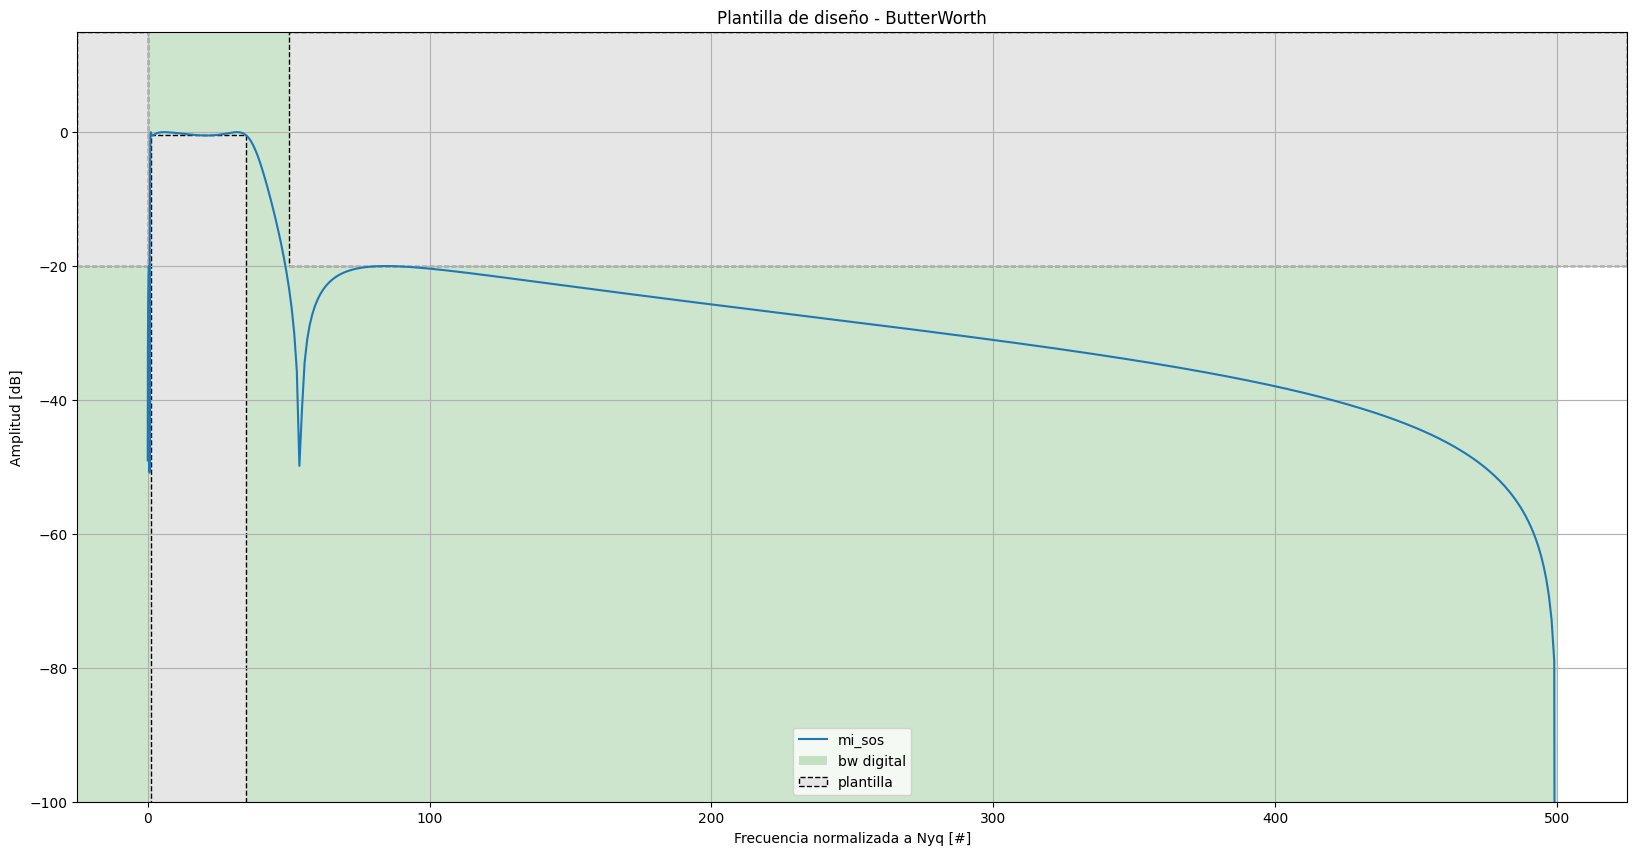

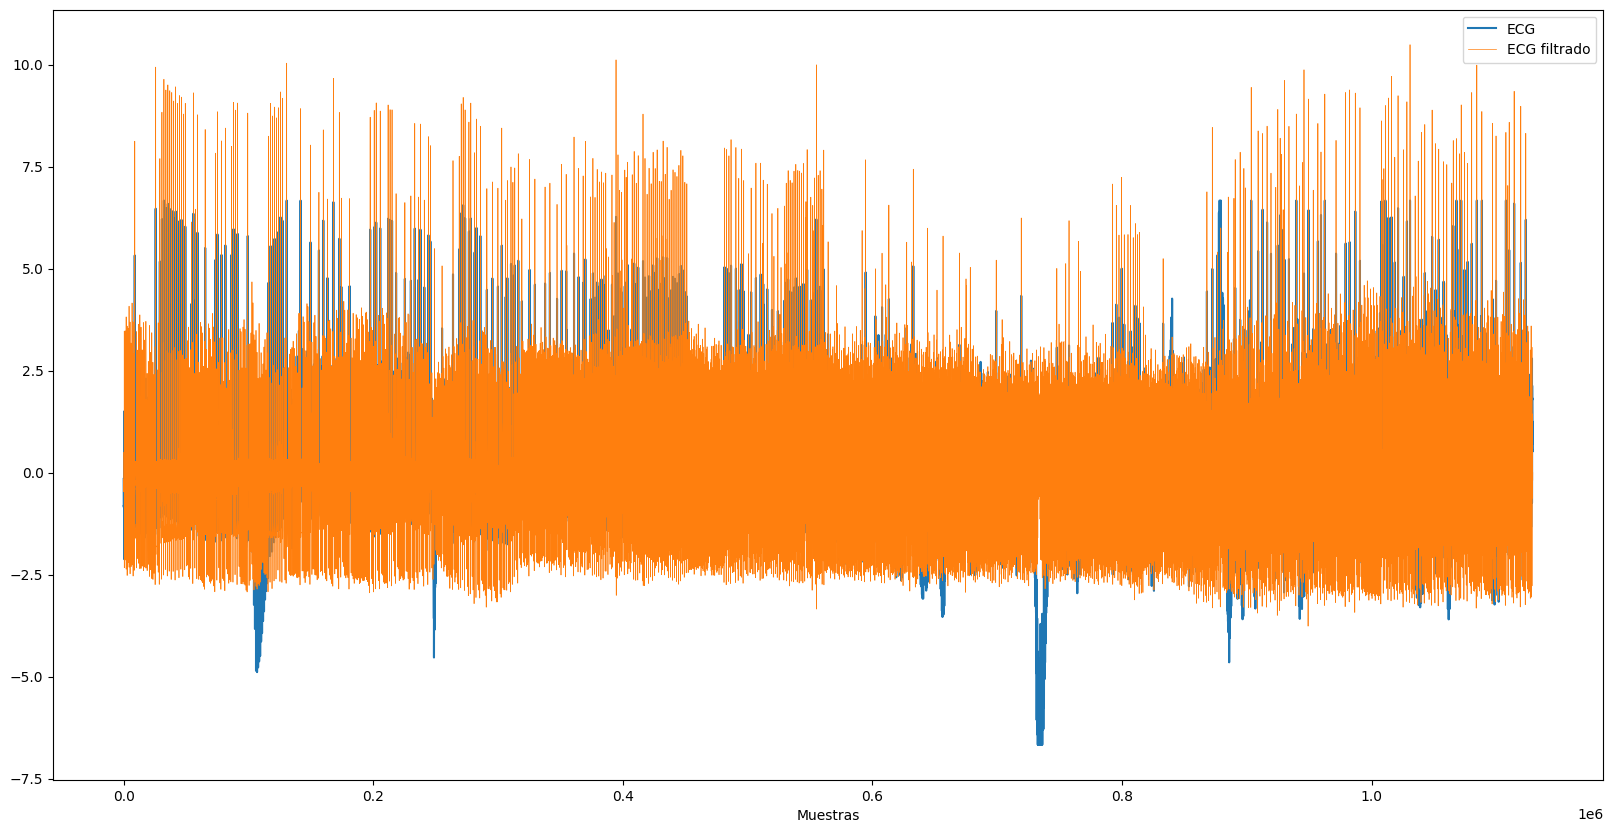

In [54]:
#%% Filtro Butter

sos_butter = sig.iirdesign(fpass, fstop, ripple, attenuation, ftype = aprox_name, output='SOS', fs=fs_ecg)

plt.figure(figsize=(20,10))

npoints = 1000

w_rad = np.append(np.logspace(-2, 0.8, 250), np.logspace(0.9, 1.6, 250) )
w_rad = np.append(w_rad, np.linspace(40, nyq_frec, 500, endpoint=True) ) / nyq_frec * np.pi #muestreo en puntos donde yo quiera. Ya no es equiespaciado. Es una plantilla logaritmica

w, hh = sig.sosfreqz(sos_butter, worN=w_rad) #w = frecuencia, hh = array de complejos

fase = np.angle(hh)

fase_des = np.unwrap(fase)

modulo = np.abs(hh)

dH = np.diff(hh)
dw = np.diff(w_rad)

retardo = dH/-dw #derivado de la fase

plt.plot(w/np.pi*nyq_frec, 20*np.log10(np.abs(hh)+1e-15), label='mi_sos')

plt.title('Plantilla de diseño - ButterWorth')
plt.xlabel('Frecuencia normalizada a Nyq [#]')
plt.ylabel('Amplitud [dB]')
plt.grid(which='both', axis='both')

ax = plt.gca()

plt.legend()
plot_plantilla(filter_type = 'bandpass' , fpass = fpass, ripple = ripple , fstop = fstop, attenuation = attenuation, fs = fs_ecg)
plt.show()

#%% Aplicacion del filtro

ecg_filt_butter = sig.sosfiltfilt(sos = sos_butter, x = ecg_signal, axis=0, padtype='odd', padlen=0)

ecg_filt_butter = ecg_filt_butter / np.std(ecg_filt_butter)

plt.figure(figsize=(20,10))
plt.plot(ecg_signal, label = 'ECG')
plt.plot(ecg_filt_butter, linewidth='0.5', label = 'ECG filtrado')
plt.xlabel('Muestras')
plt.legend()
plt.show()

### Cauer

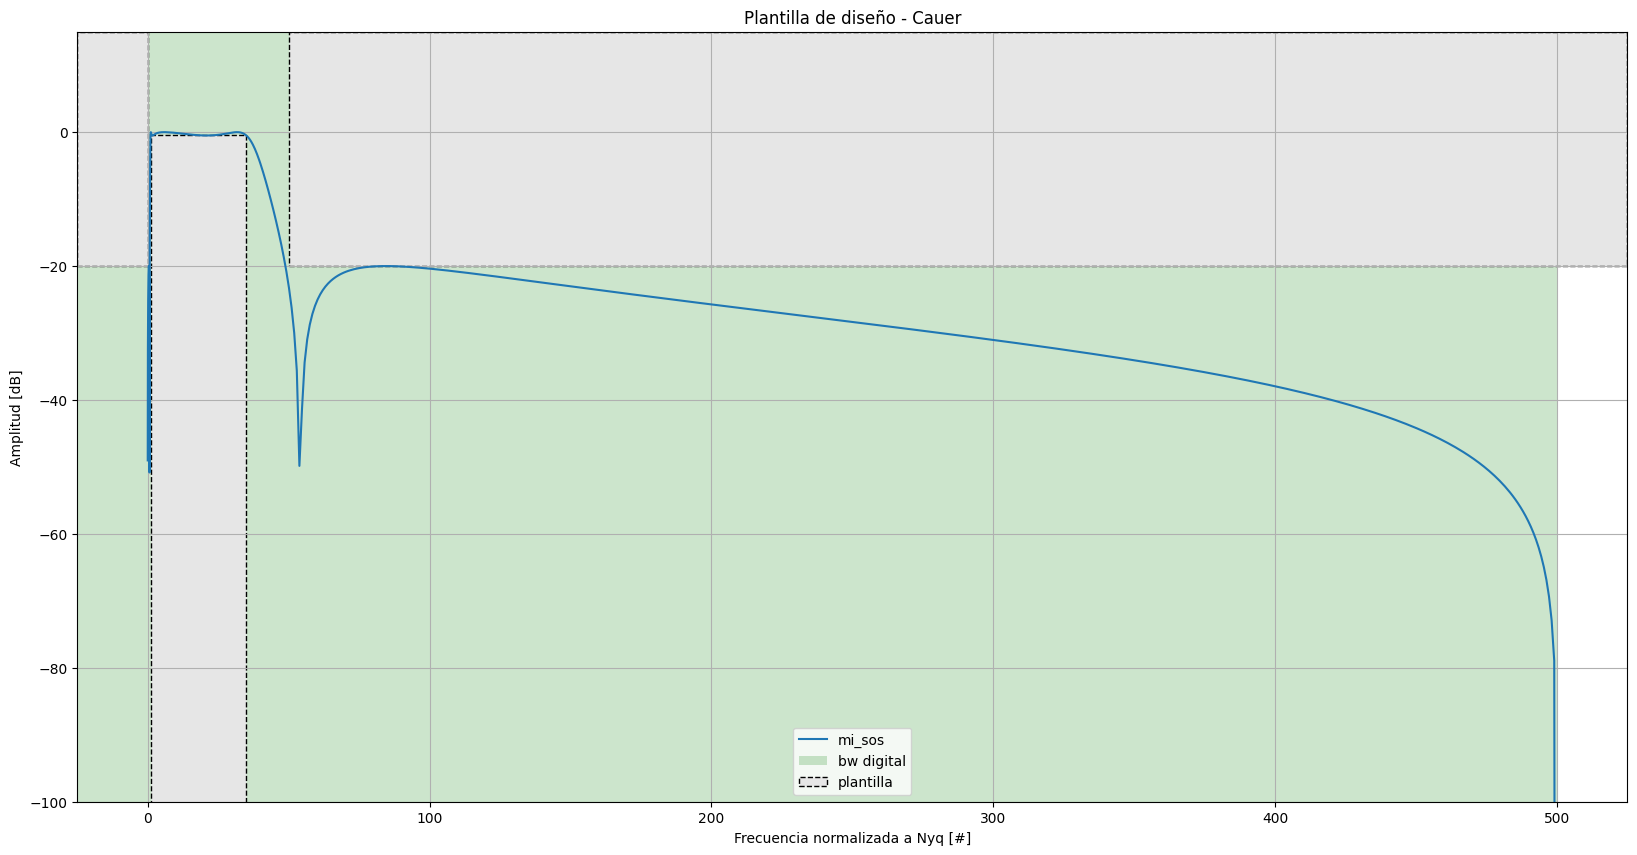

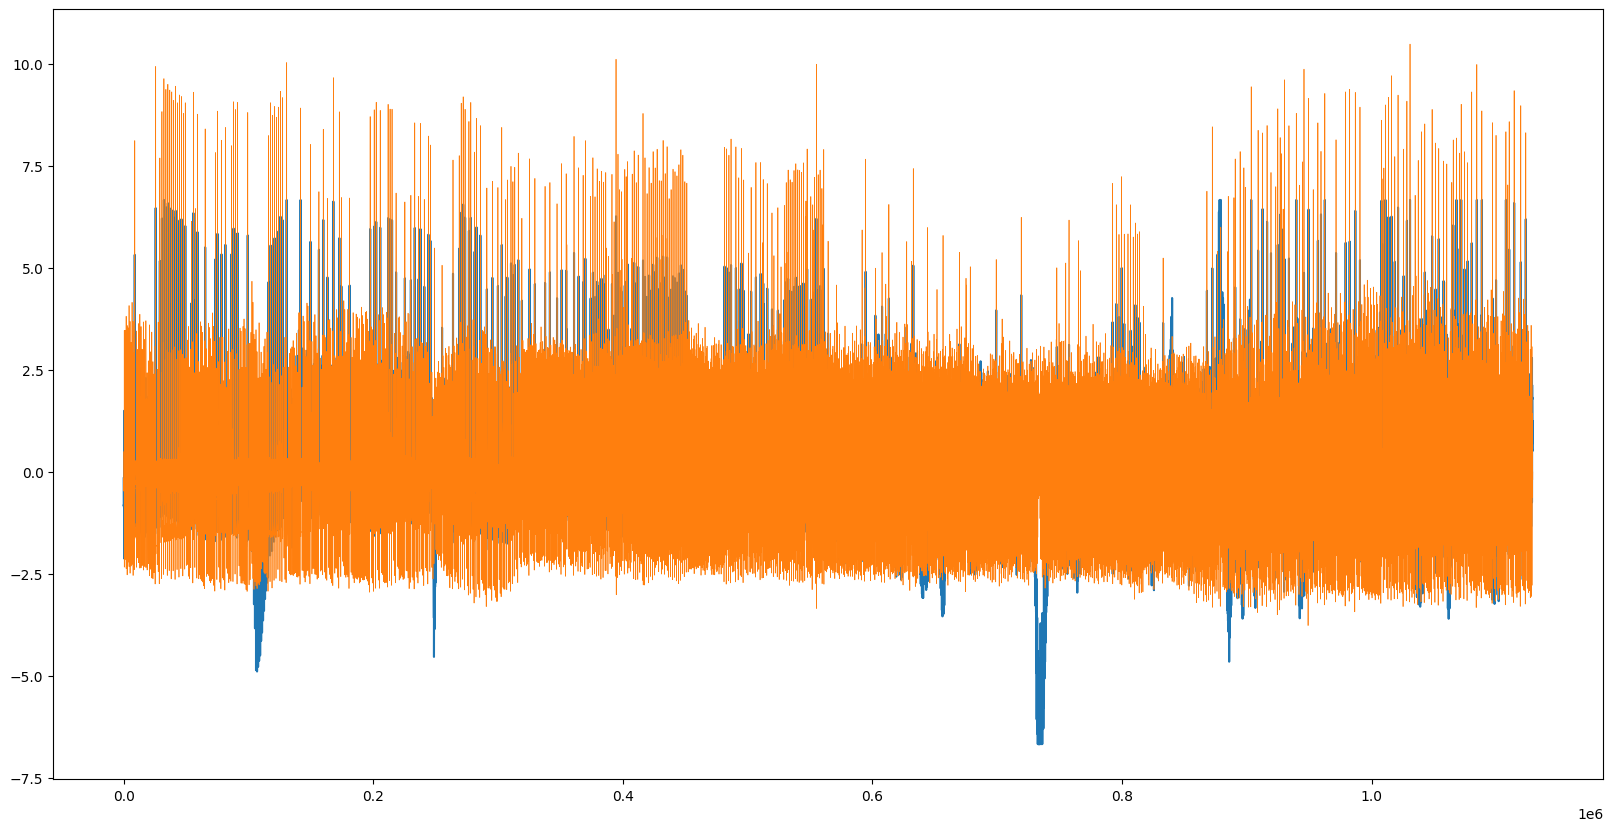

In [ ]:
#%% Cauer

aprox_name = 'ellip'

sos_cauer = sig.iirdesign(fpass, fstop, ripple, attenuation, ftype = aprox_name, output='SOS', fs=fs_ecg)

plt.figure(figsize=(20,10))

npoints = 1000

w_rad = np.append(np.logspace(-2, 0.8, 250), np.logspace(0.9, 1.6, 250) )
w_rad = np.append(w_rad, np.linspace(40, nyq_frec, 500, endpoint=True) ) / nyq_frec * np.pi #muestreo en puntos donde yo quiera. Ya no es equiespaciado. Es una plantilla logaritmica

w, hh = sig.sosfreqz(sos_cauer, worN=w_rad) #w = frecuencia, hh = array de complejos

fase = np.angle(hh)

fase_des = np.unwrap(fase)

modulo = np.abs(hh)

dH = np.diff(hh)
dw = np.diff(w_rad)

retardo = dH/-dw #derivado de la fase

plt.plot(w/np.pi*nyq_frec, 20*np.log10(np.abs(hh)+1e-15), label='mi_sos')

plt.title('Plantilla de diseño - Cauer')
plt.xlabel('Frecuencia normalizada a Nyq [#]')
plt.ylabel('Amplitud [dB]')
plt.grid(which='both', axis='both')

ax = plt.gca()

plt.legend()
plot_plantilla(filter_type = 'bandpass' , fpass = fpass, ripple = ripple , fstop = fstop, attenuation = attenuation, fs = fs_ecg)
plt.show()

tramo = np.arange(100000-9000,200000-9000,1)

ecg_filt_cauer = sig.sosfiltfilt(sos = sos_cauer, x = ecg_signal, axis=0, padtype='odd', padlen=0)
ecg_filt_cauer = ecg_filt_cauer / np.std(ecg_filt_cauer)

plt.figure(figsize=(20,10))
plt.plot(ecg_signal, label = 'ECG')
plt.plot(ecg_filt_cauer, linewidth='0.5', label = 'ECG filtrado')
plt.xlabel('Muestras')
plt.legend()
plt.show()

### Kaiser

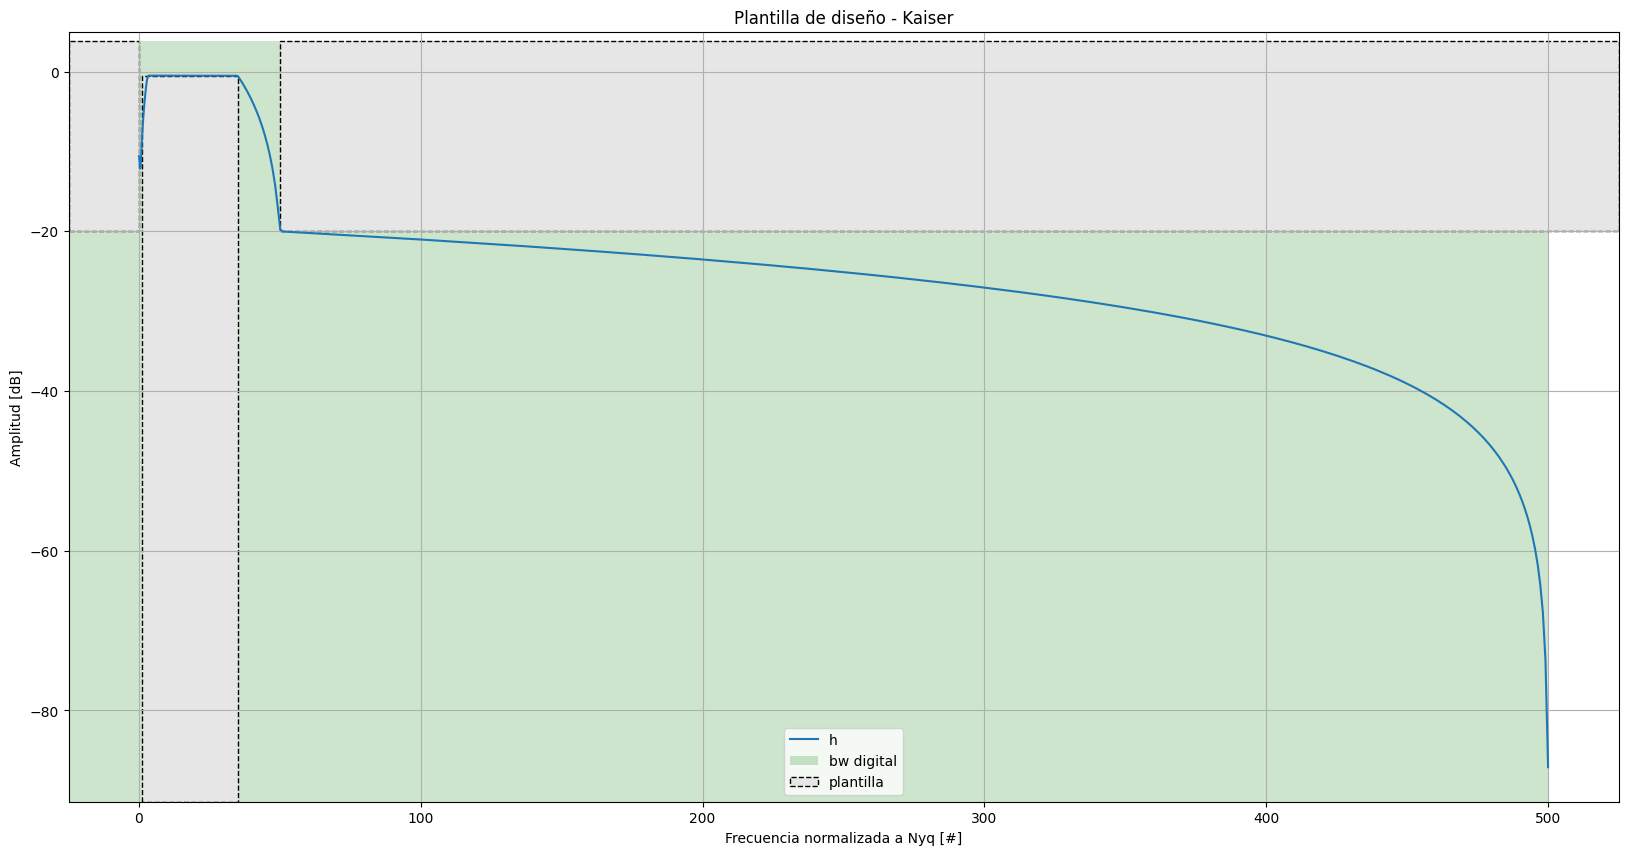

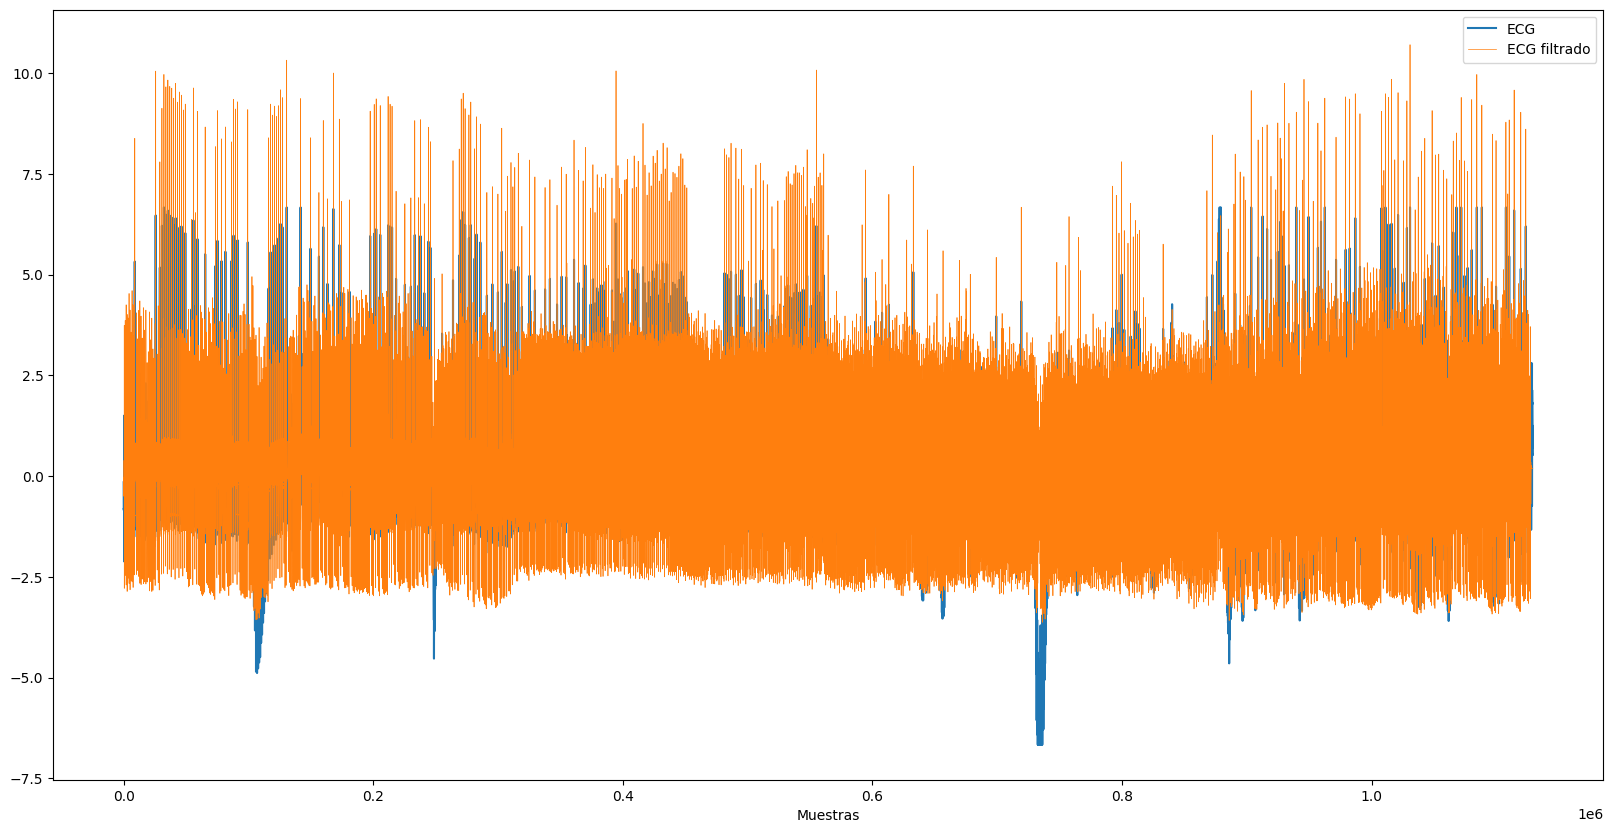

In [55]:
#%% Kaiser

cant_coef = 2907

frecs = [0, 0.1, 3, 35, 50, fs_ecg/2]
gain = [0, -attenuation, -ripple, -ripple, -attenuation, -np.inf]

gain = 10**(np.array(gain)/20)

h = sig.firwin2(cant_coef, frecs, gain, window = ('kaiser', 6), fs=fs_ecg)

plt.figure(figsize=(20,10))

npoints = 1000

w_rad = np.append(np.logspace(-2, 0.8, 250), np.logspace(0.9, 1.6, 250) )
w_rad = np.append(w_rad, np.linspace(40, nyq_frec, 500, endpoint=True) ) / nyq_frec * np.pi #muestreo en puntos donde yo quiera. Ya no es equiespaciado. Es una plantilla logaritmica

w, hh = sig.freqz(h, worN=w_rad)

plt.plot(w/np.pi*nyq_frec, 20*np.log10(np.abs(hh)+1e-15), label='h')

plt.title('Plantilla de diseño - Kaiser')
plt.xlabel('Frecuencia normalizada a Nyq [#]')
plt.ylabel('Amplitud [dB]')
plt.grid(which='both', axis='both')

ax = plt.gca()

plt.legend()
plot_plantilla(filter_type = 'bandpass' , fpass = fpass, ripple = ripple , fstop = fstop, attenuation = attenuation, fs = fs_ecg)
plt.show()

ecg_filt_kaiser = sig.filtfilt(h, 1, x = ecg_signal.flatten(), axis=-1, padtype='odd', padlen=0)
ecg_filt_kaiser = ecg_filt_kaiser / np.std(ecg_filt_kaiser)

plt.figure(figsize=(20,10))
plt.plot(ecg_signal, label = 'ECG')
plt.plot(ecg_filt_kaiser, linewidth='0.5', label = 'ECG filtrado')
plt.xlabel('Muestras')
plt.legend()
plt.show()

### Cuadrados mínimos

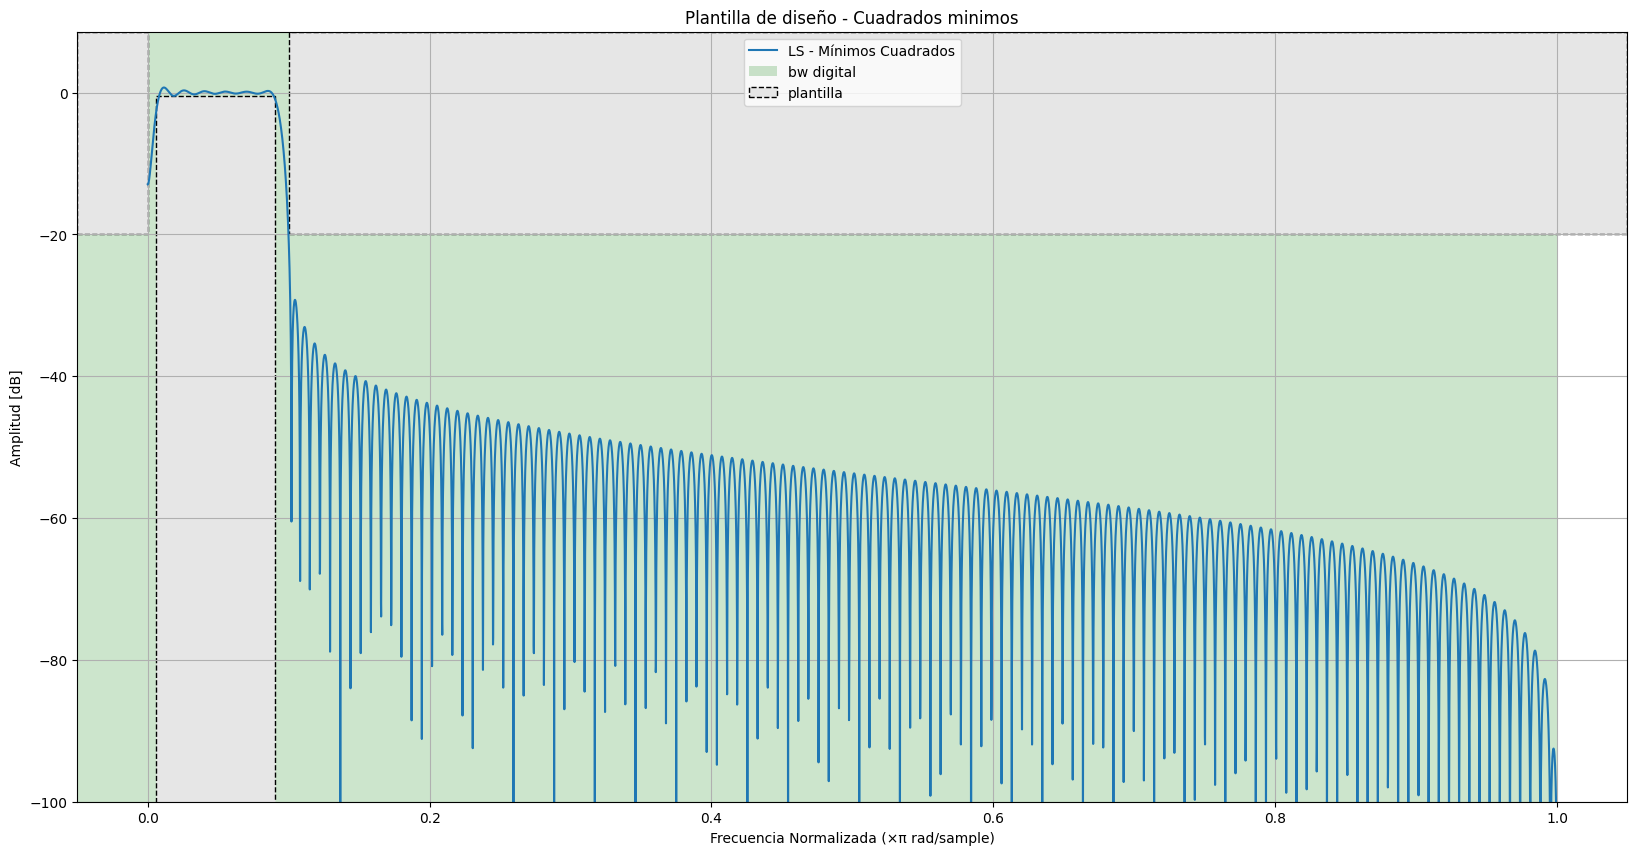

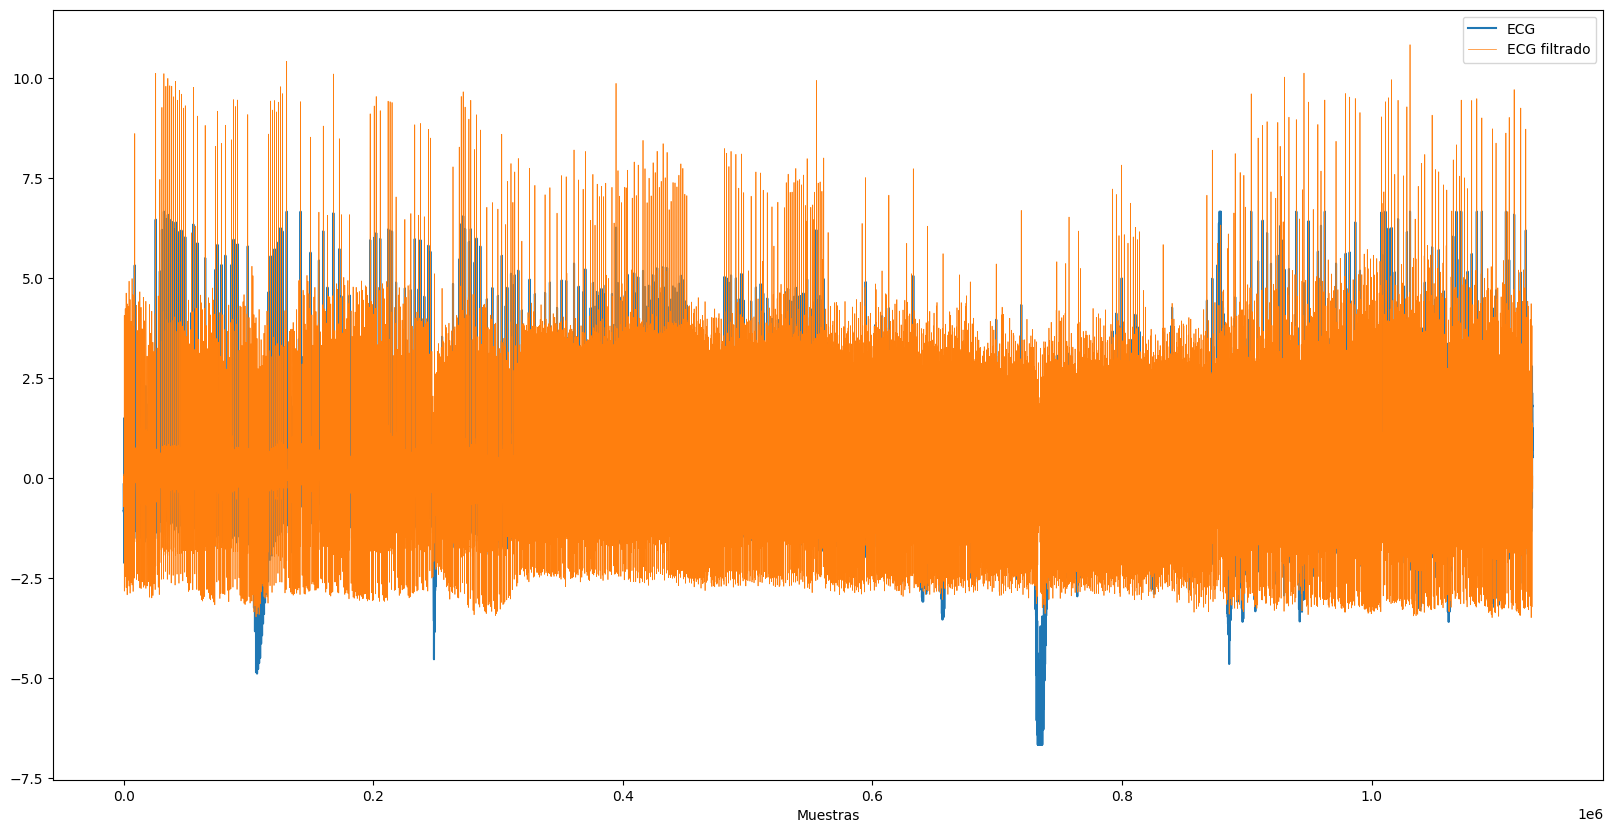

In [56]:
#%% Cuadrados minimos 

# Parámetros comunes del filtro Pasa Banda
order = 277  # Aumentamos el orden para mejor selectividad
fs = 2.0
fpass1 = 3 / nyq_frec  # Frecuencia de paso inferior
fpass2 = 45 / nyq_frec  # Frecuencia de paso superior
fstop1 = 0.001 / nyq_frec  # Frecuencia de corte inferior
fstop2 = 50 / nyq_frec  # Frecuencia de corte superior
ripple = 0.5 # dB
attenuation = 20  # dB
lgrid = 20

# Definir las bandas de paso y corte
band_edges = [0, fstop1, fpass1, fpass2, fstop2, 1.0]
desired = [0, 0, 1, 1, 0, 0]

# Desviaciones permisibles en dB
d = np.array([-ripple, -attenuation])  # En dB
d = 10**(d/20)  # Convertir de dB a lineal
d = np.array([(1-d[0]), d[1]])

# Diseño del filtro con LS
b_ls = pytc2.filtros_digitales.fir_design_ls(order, band_edges, desired, grid_density=lgrid, fs=fs, filter_type='m')

# Comparar la respuesta en frecuencia de ambos filtros
w, h_ls = sig.freqz(b_ls, worN=8000)

# Graficar ambas respuestas
plt.figure(figsize=(20, 10))
plt.plot(w/np.pi, 20 * np.log10(np.abs(h_ls)), label='LS - Mínimos Cuadrados', linestyle='-')
plt.title('Plantilla de diseño - Cuadrados minimos')
plt.xlabel('Frecuencia Normalizada (×π rad/sample)')
plt.ylabel('Amplitud [dB]')
plt.legend()
plt.grid()
plot_plantilla(filter_type = 'bandpass' , fpass = (fpass1, fpass2), ripple = ripple , fstop = (fstop1, fstop2), attenuation = attenuation, fs = fs)
plt.show()

ecg_filt_ls = sig.filtfilt(b_ls, [1], ecg_one_lead.flatten(), axis=-1, padtype='odd', padlen=1000)
ecg_filt_ls = ecg_filt_ls / np.std(ecg_filt_ls)

plt.figure(figsize=(20,10))
plt.plot(ecg_signal, label = 'ECG')
plt.plot(ecg_filt_ls, linewidth='0.5', label = 'ECG filtrado')
plt.xlabel('Muestras')
plt.legend()
plt.show()

## Punto d) - Evaluación de rendimiento

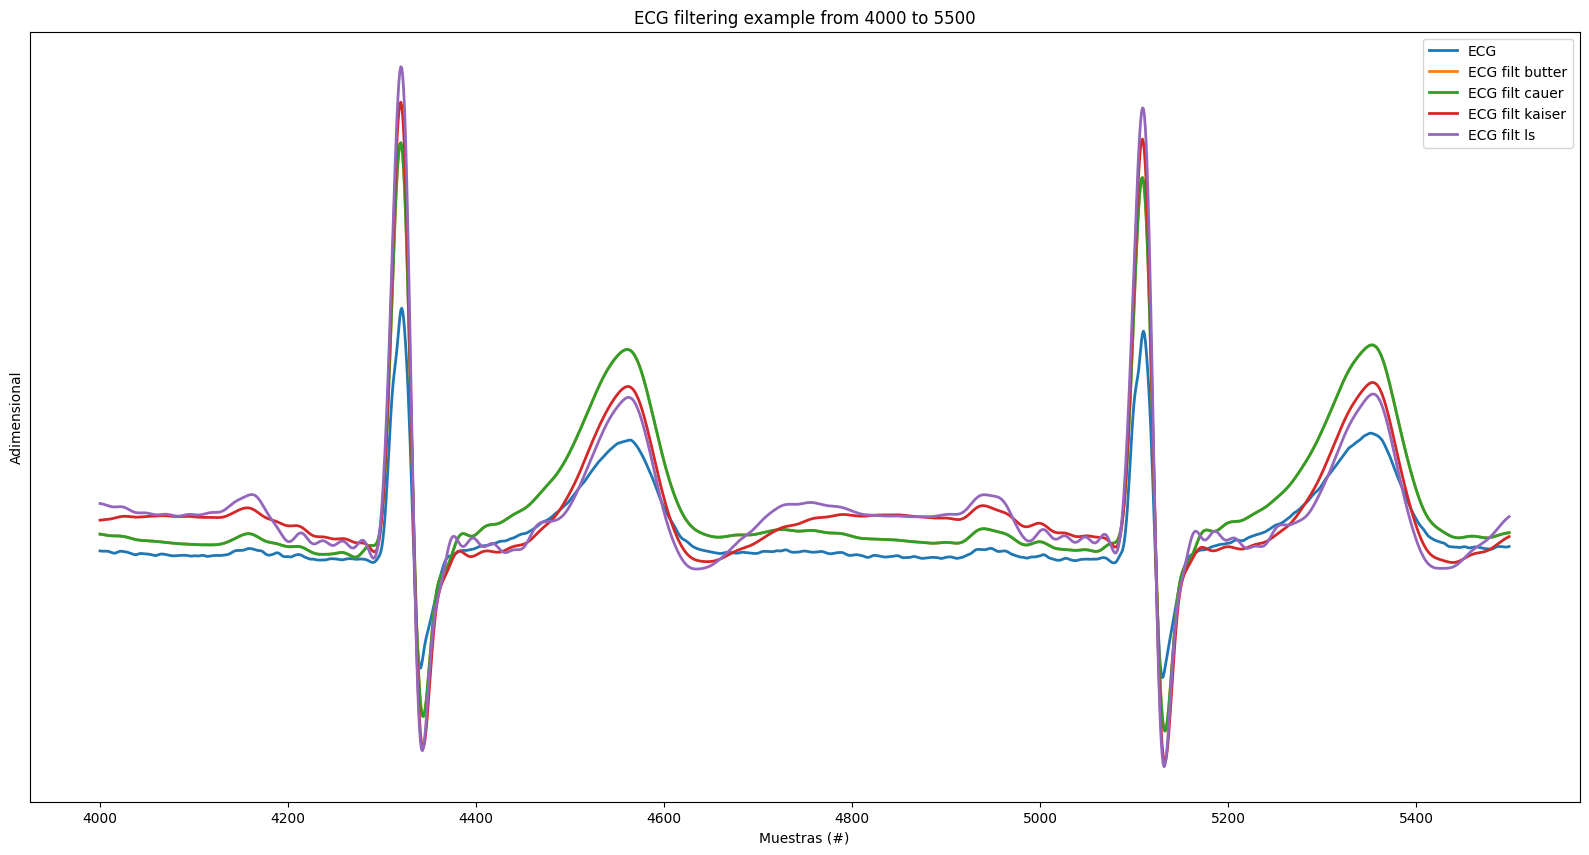

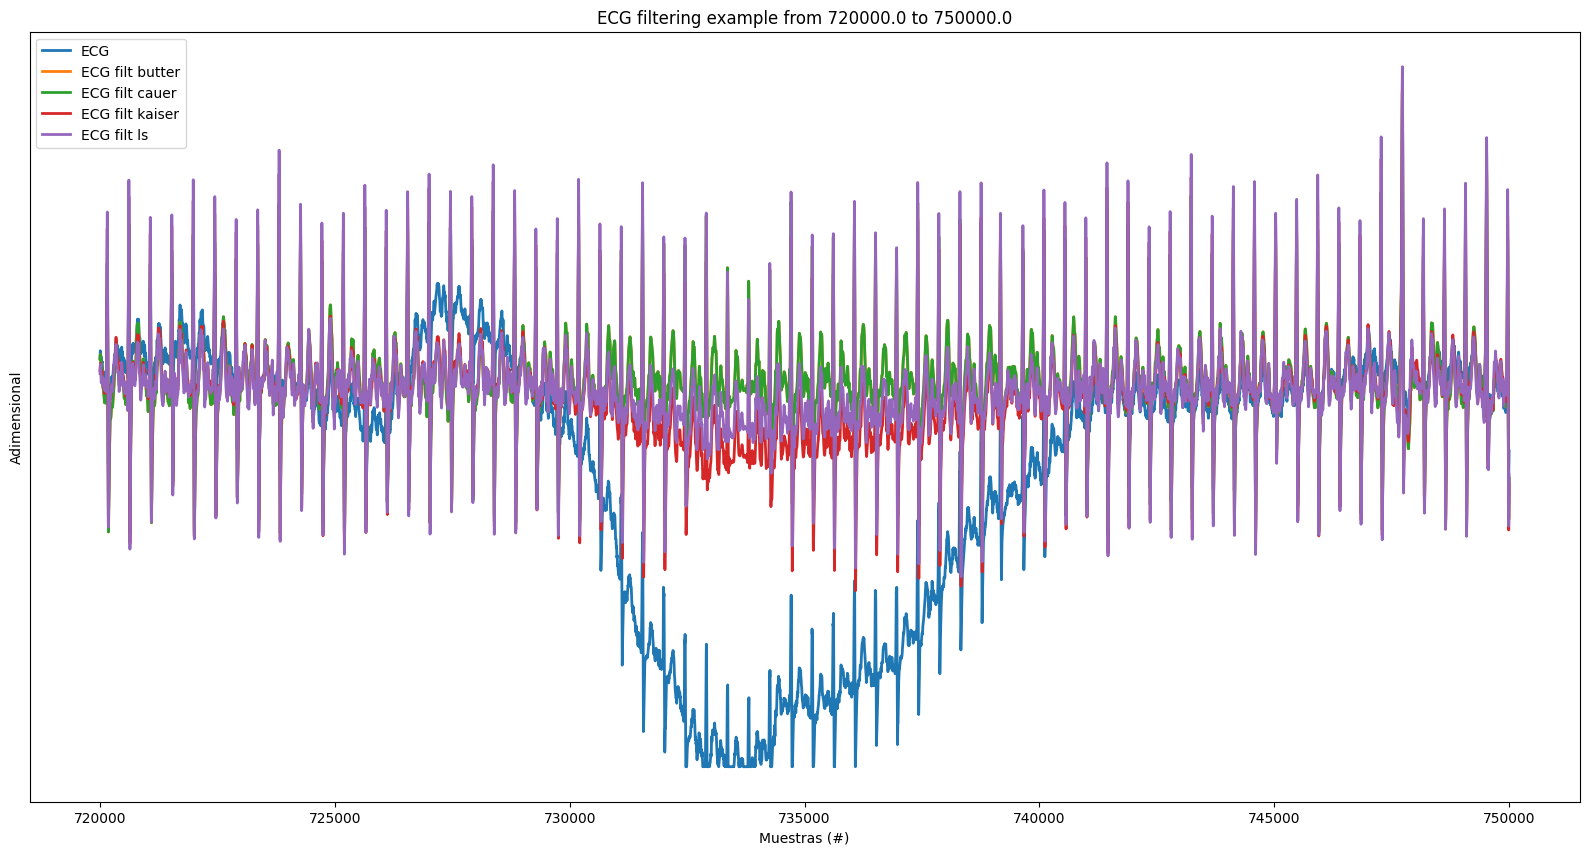

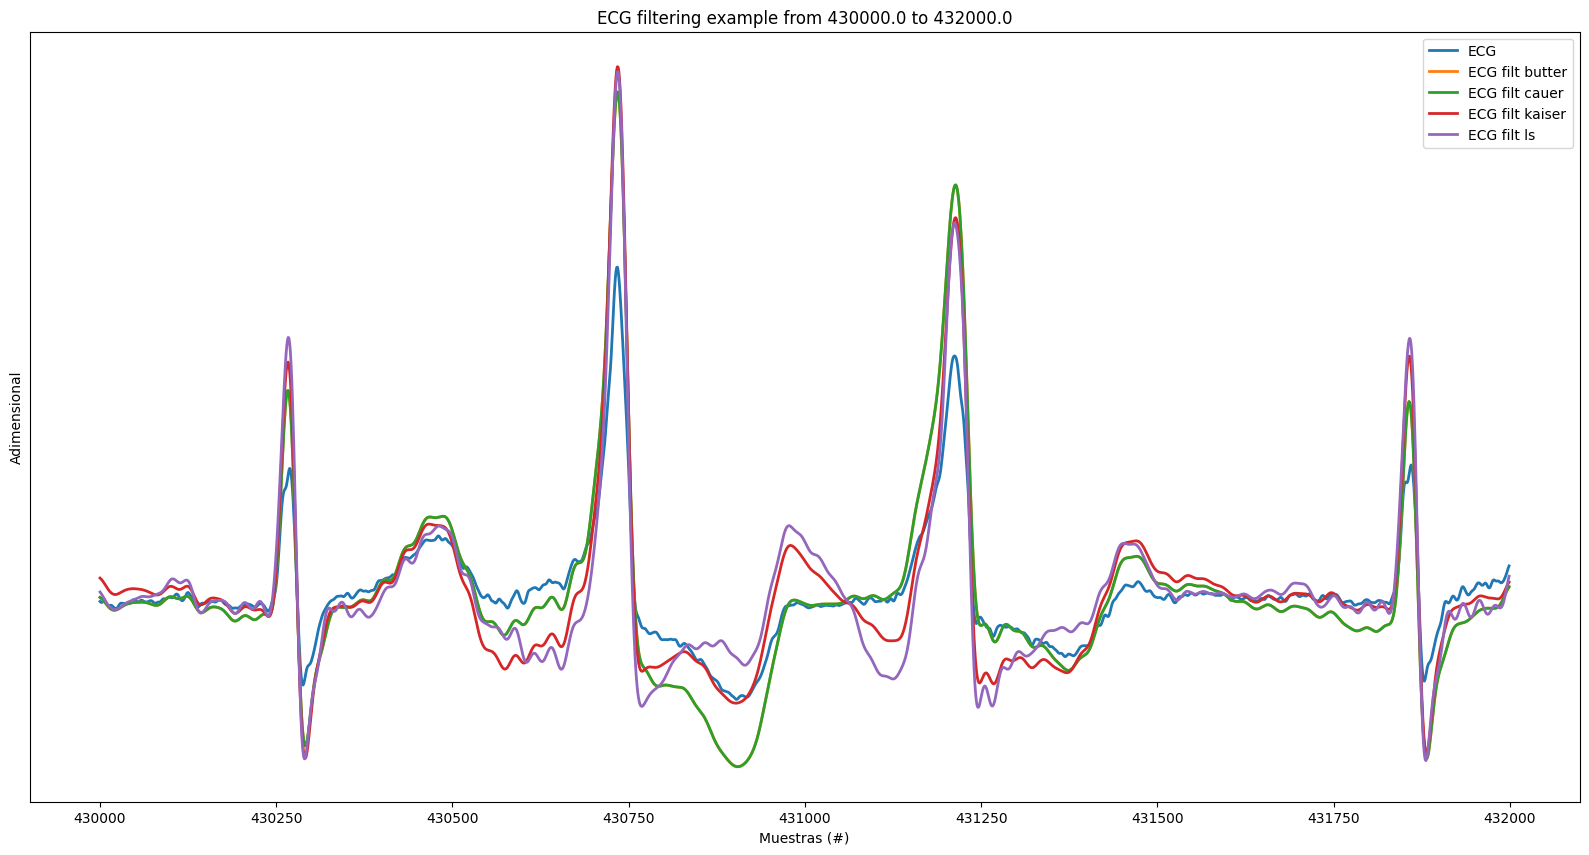

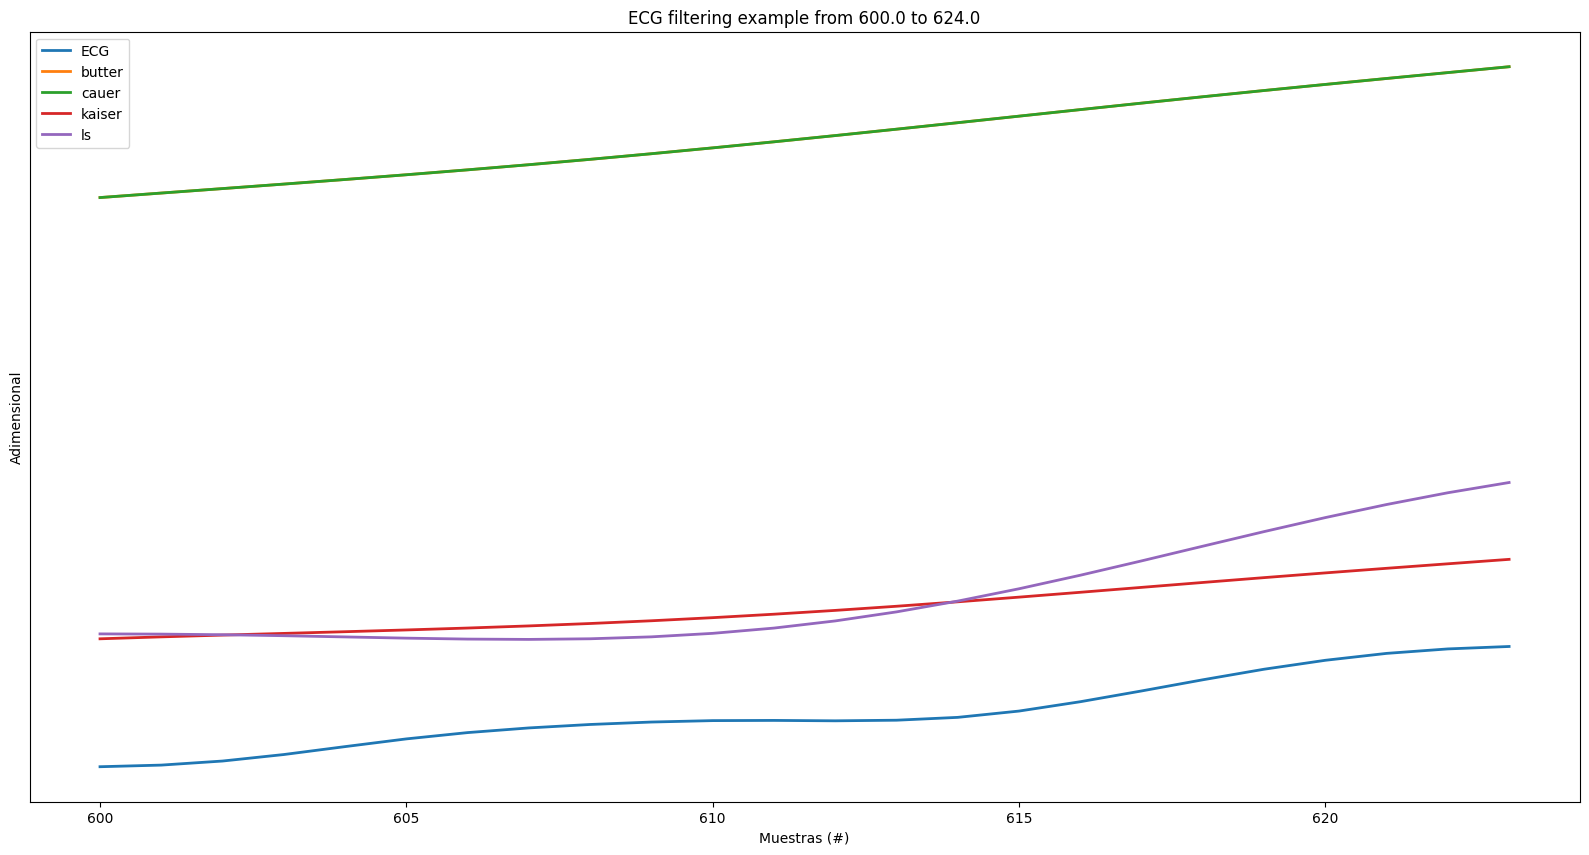

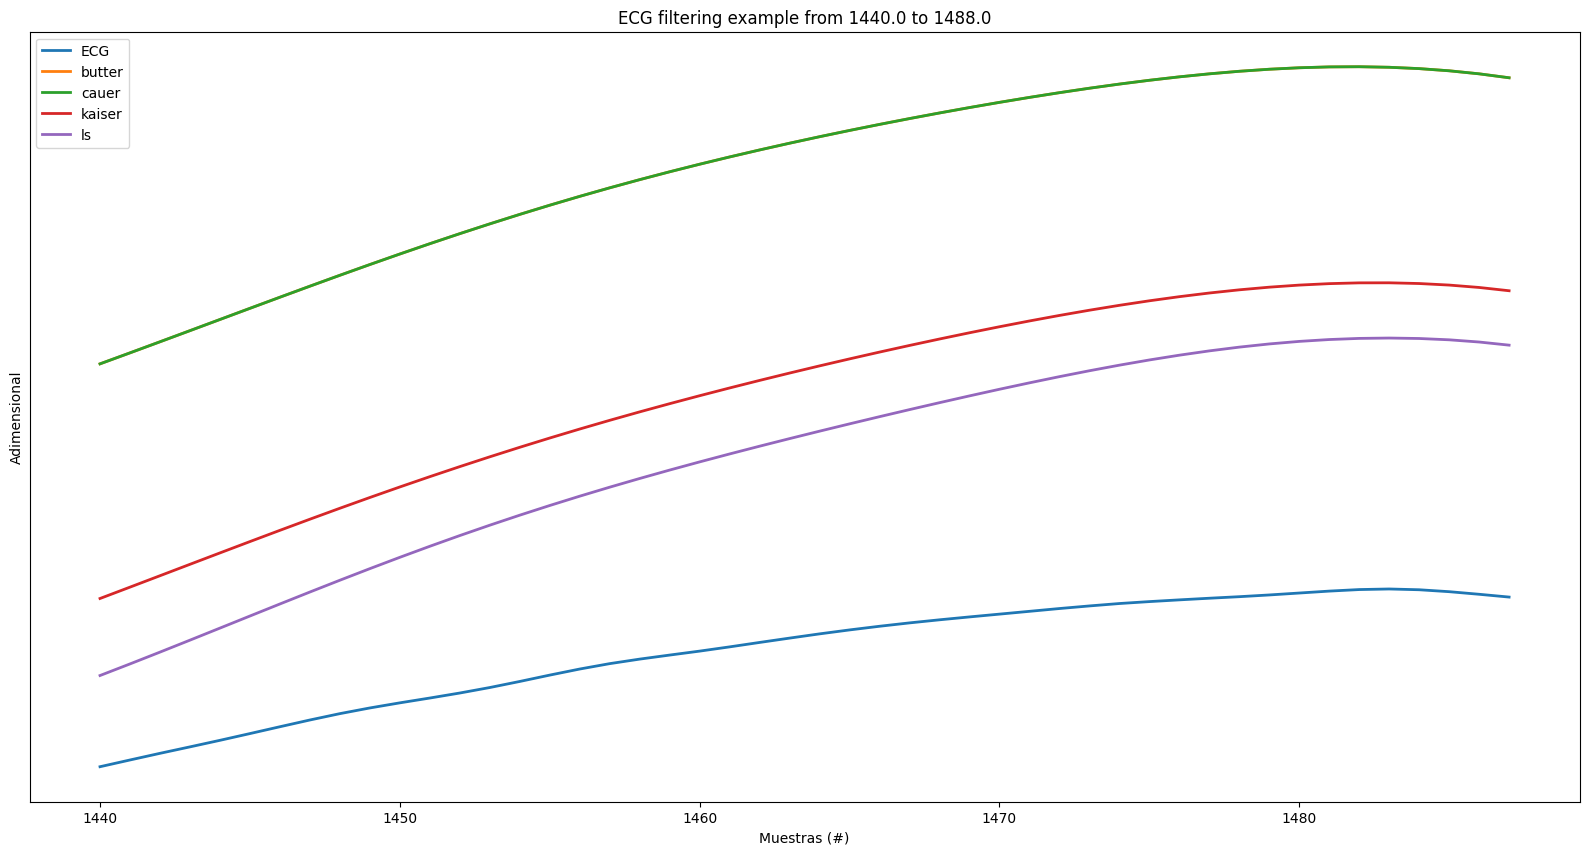

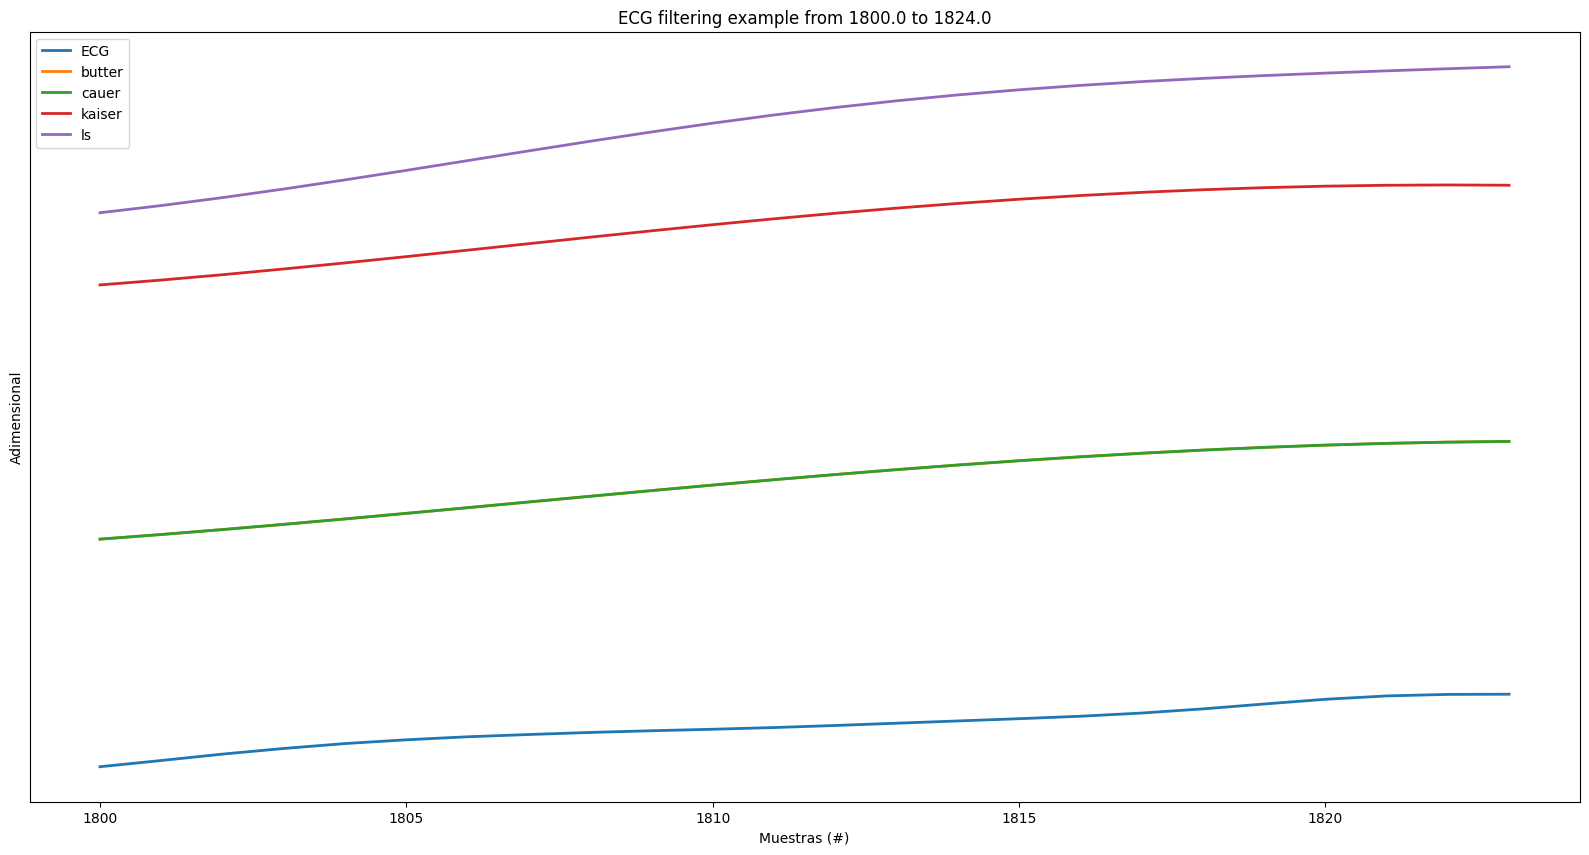

In [49]:
###################################
#%% Regiones de interés con ruido #
###################################
 
cant_muestras = len(ecg_signal)

regs_interes = (
        [4000, 5500], # muestras
        [7.2e5, 7.5e5],
        [4.3e5, 4.32e5], # muestras
        )
 
for ii in regs_interes:
   
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
   
    plt.figure(figsize = (20,10))
    plt.plot(zoom_region, ecg_signal[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ecg_filt_butter[zoom_region], label='ECG filt butter', linewidth=2)
    plt.plot(zoom_region, ecg_filt_cauer[zoom_region], label='ECG filt cauer', linewidth=2)
    plt.plot(zoom_region, ecg_filt_kaiser[zoom_region], label='ECG filt kaiser', linewidth=2)
    plt.plot(zoom_region, ecg_filt_ls[zoom_region], label='ECG filt ls', linewidth=2)

    #plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butterworth')
    #plt.plot(zoom_region, ECG_f_win[zoom_region + demora], label='FIR Window')
   
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]))
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
   
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
           
    plt.show()
 
###################################
#%% Regiones de interés sin ruido #
###################################
 
regs_interes = (
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )
 
for ii in regs_interes:
   
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
   
    plt.figure(figsize=(20,10))
    plt.plot(zoom_region, ecg_signal[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ecg_filt_butter[zoom_region], label='butter', linewidth=2)
    plt.plot(zoom_region, ecg_filt_cauer[zoom_region], label='cauer', linewidth=2)
    plt.plot(zoom_region, ecg_filt_kaiser[zoom_region], label='kaiser', linewidth=2)
    plt.plot(zoom_region, ecg_filt_ls[zoom_region], label='ls', linewidth=2)
   
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
   
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
           
    plt.show()

Como es posible observar, los filtros de Butterworth y Cauer presentan una implementación más sencilla y unos resultados más satisfactorios, logrando una buena supresión de las bajas frecuencias y comportandose decentemente en las altas frecuencias. Por otro lado, en las zonas de bajo ruido, exceptuando en zonas concretas, fueron las que más similitud guardaron con la señal de base.

Contrariamente, los resultados conseguidos con los filtros Kaiser y de Cuadrados mínimos también fueron aceptables. Sin embargo, se requirió de un mayor costo computacional y, por su respuesta al impulso, se debió modificar la plantilla original, a fin de adaptarla a los requirimientos de estos filtros. Aún así, por ejemplo en las zonas de ruido de baja frecuencia, se comportan de peor forma que sus contrapartes IIR.